In [1]:
from load_dataset.artgraph import ArtGraph
from utils.MultiTaskLinkSplitter import MultiTaskLinkSplitter
from utils.dataset import TrainingDataSet, TestDataSet, SingleTaskTestDataSet, SingleTaskTrainingDataSet
from utils.EarlyStopping import EarlyStopping
from multi_task_model import MultiTaskClassificationModel, NewMultiTaskClassificationModel
from torch import nn
from utils.training_utils import fine_tune, test as test_func, compute_topk, plot_confusion_matrix, fine_tune_single_task, test_single_task
from torch.utils.data import DataLoader
from torch import optim
import torch
import pandas as pd
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
%matplotlib inline

In [2]:
from torch_geometric.seed import seed_everything
seed_everything(1)

In [3]:
root = 'artgraph2bestemotions'
data_path = 'data_full_labels.csv'

In [4]:
pos_neg_emotions = {8:2}
pos_neg_emotions.update({x:0 for x in (1, 2, 3, 5)})
pos_neg_emotions.update({x:1 for x in (0, 4, 6, 7)})

In [5]:
data = ArtGraph(root = root, preprocess='constant', features = 'vit', fine_tuning = True)[0]
data

Processing...
Done!


HeteroData(
  artwork={ x=[116475, 128] },
  artist={ x=[2501, 1] },
  gallery={ x=[1099, 1] },
  city={ x=[596, 1] },
  country={ x=[58, 1] },
  style={ x=[32, 1] },
  period={ x=[186, 1] },
  genre={ x=[18, 1] },
  serie={ x=[823, 1] },
  tag={ x=[5424, 1] },
  media={ x=[167, 1] },
  subject={ x=[6985, 1] },
  training_node={ x=[268, 1] },
  field={ x=[54, 1] },
  movement={ x=[243, 1] },
  people={ x=[109, 1] },
  emotion={ x=[9, 1] },
  (artist, belongstofield, field)={ edge_index=[2, 987] },
  (artist, belongstomovement, movement)={ edge_index=[2, 1056] },
  (artist, haspatron, people)={ edge_index=[2, 124] },
  (artist, hassubject, subject)={ edge_index=[2, 21054] },
  (artist, relatedtoschool, training_node)={ edge_index=[2, 498] },
  (artist, trainedby, artist)={ edge_index=[2, 47] },
  (artwork, about, tag)={ edge_index=[2, 342982] },
  (artwork, createdby, artist)={ edge_index=[2, 116475] },
  (artwork, elicit, emotion)={ edge_index=[2, 65236] },
  (artwork, hasgenre, genre)

In [6]:
emotion_value = data['emotion'].x[0].item()
data['emotion'].x = torch.full(size = (3, 1), fill_value = emotion_value)

emotion_entries = data['artwork', 'emotion'].edge_index[1].tolist()
data['artwork', 'emotion'].edge_index[1] = torch.Tensor(list(map(lambda x: pos_neg_emotions[x], emotion_entries)))
data

HeteroData(
  artwork={ x=[116475, 128] },
  artist={ x=[2501, 1] },
  gallery={ x=[1099, 1] },
  city={ x=[596, 1] },
  country={ x=[58, 1] },
  style={ x=[32, 1] },
  period={ x=[186, 1] },
  genre={ x=[18, 1] },
  serie={ x=[823, 1] },
  tag={ x=[5424, 1] },
  media={ x=[167, 1] },
  subject={ x=[6985, 1] },
  training_node={ x=[268, 1] },
  field={ x=[54, 1] },
  movement={ x=[243, 1] },
  people={ x=[109, 1] },
  emotion={ x=[3, 1] },
  (artist, belongstofield, field)={ edge_index=[2, 987] },
  (artist, belongstomovement, movement)={ edge_index=[2, 1056] },
  (artist, haspatron, people)={ edge_index=[2, 124] },
  (artist, hassubject, subject)={ edge_index=[2, 21054] },
  (artist, relatedtoschool, training_node)={ edge_index=[2, 498] },
  (artist, trainedby, artist)={ edge_index=[2, 47] },
  (artwork, about, tag)={ edge_index=[2, 342982] },
  (artwork, createdby, artist)={ edge_index=[2, 116475] },
  (artwork, elicit, emotion)={ edge_index=[2, 65236] },
  (artwork, hasgenre, genre)

In [7]:
mls = MultiTaskLinkSplitter(seed = 1)
train, val, test = mls.transform(data)
train

HeteroData(
  artwork={ x=[116475, 128] },
  artist={ x=[2501, 1] },
  gallery={ x=[1099, 1] },
  city={ x=[596, 1] },
  country={ x=[58, 1] },
  style={ x=[32, 1] },
  period={ x=[186, 1] },
  genre={ x=[18, 1] },
  serie={ x=[823, 1] },
  tag={ x=[5424, 1] },
  media={ x=[167, 1] },
  subject={ x=[6985, 1] },
  training_node={ x=[268, 1] },
  field={ x=[54, 1] },
  movement={ x=[243, 1] },
  people={ x=[109, 1] },
  emotion={ x=[3, 1] },
  (artist, belongstofield, field)={ edge_index=[2, 987] },
  (artist, belongstomovement, movement)={ edge_index=[2, 1056] },
  (artist, haspatron, people)={ edge_index=[2, 124] },
  (artist, hassubject, subject)={ edge_index=[2, 21054] },
  (artist, relatedtoschool, training_node)={ edge_index=[2, 498] },
  (artist, trainedby, artist)={ edge_index=[2, 47] },
  (artwork, about, tag)={ edge_index=[2, 181644] },
  (artwork, createdby, artist)={ edge_index=[2, 52188] },
  (artwork, elicit, emotion)={ edge_index=[2, 52188] },
  (artwork, hasgenre, genre)=

In [8]:
#loading data with labels
data_labels = pd.read_csv(data_path)
data_labels.emotion = data_labels.emotion.map(pos_neg_emotions)
data_labels.index = data_labels.artwork
data_labels

,artwork,style,genre,emotion
artwork,,,,
81418,81418,1,4,1
28493,28493,3,9,0
28421,28421,3,3,2
28393,28393,3,9,2
28380,28380,3,9,1
...,...,...,...,...
71300,71300,10,6,2
68290,68290,23,6,2
68567,68567,23,6,2


In [9]:
from torch_geometric.transforms import ToUndirected
batch_size = 128
num_epochs = 50
device = torch.device('cuda:0')
train = ToUndirected()(train).to(device)

In [10]:
from model import ModelClassification
task = 'emotion'
print(f"{'*'*50}{task.upper()}{'*'*50}")
train_dataset = SingleTaskTrainingDataSet(train, data_labels, task)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

val_dataset = SingleTaskTestDataSet(val, data_labels, train, task)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=False)


model = ModelClassification(data = train, hidden_channels = 128, out_channels = train[task].x.shape[0],
                           obj = task, head_num_layers = 5, gnn_activation = torch.nn.Tanh(),
                           head_activation = torch.nn.LeakyReLU, drop_rate = 0.25,
                           shared=True, gnn_mean =False, bnorm=False).to(device)

with torch.no_grad():
    model.encoder(train.x_dict, train.edge_index_dict)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
early_stop = EarlyStopping(patience = 5, min_delta = 1e-3, checkpoint_path = f'best_model_{task}_single_task_ternary.pt')
criterion = torch.nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr = 1e-7, verbose = True, factor = .5, patience = 1,
                                           threshold = 1e-4)
fine_tune_single_task(model, train, train_loader, val_loader, criterion, optimizer, early_stop, scheduler,
                     num_epochs)

**************************************************EMOTION**************************************************


D:\Anaconda\envs\tesi\lib\site-packages\torch_geometric\nn\conv\hetero_conv.py:53: UserWarning: There exist node types ({'artwork'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behaviour.
  warnings.warn(


Epoch 1/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:11<00:00, 36.31it/s]


train Loss: 0.8945 Style Acc: 0.6005


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 70.77it/s]


val Loss: 0.8378 Style Acc: 0.6236
Validation loss decreased. Saving model...
Epoch 2/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:07<00:00, 56.50it/s]


train Loss: 0.8334 Style Acc: 0.6392


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 76.62it/s]


val Loss: 0.8190 Style Acc: 0.6443
Validation loss decreased. Saving model...
Epoch 3/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:07<00:00, 55.35it/s]


train Loss: 0.8228 Style Acc: 0.6467


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 73.74it/s]


val Loss: 0.8155 Style Acc: 0.6461
Validation loss decreased. Saving model...
Epoch 4/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:07<00:00, 57.07it/s]


train Loss: 0.8155 Style Acc: 0.6507


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 70.38it/s]


val Loss: 0.8124 Style Acc: 0.6472
Validation loss decreased. Saving model...
Epoch 5/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:07<00:00, 56.48it/s]


train Loss: 0.8105 Style Acc: 0.6542


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 82.32it/s]


val Loss: 0.8109 Style Acc: 0.6483
Validation loss decreased. Saving model...
Epoch 6/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:07<00:00, 56.60it/s]


train Loss: 0.8063 Style Acc: 0.6554


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 77.20it/s]


val Loss: 0.8097 Style Acc: 0.6512
Validation loss decreased. Saving model...
Epoch 7/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:07<00:00, 57.99it/s]


train Loss: 0.8042 Style Acc: 0.6569


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 79.74it/s]


val Loss: 0.8095 Style Acc: 0.6501
EarlyStopping counter: 1 out of 5
Epoch 8/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:07<00:00, 56.09it/s]


train Loss: 0.8010 Style Acc: 0.6578


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 81.01it/s]


val Loss: 0.8087 Style Acc: 0.6536
EarlyStopping counter: 2 out of 5
Epoch 9/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:07<00:00, 57.83it/s]


train Loss: 0.7962 Style Acc: 0.6620


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 77.79it/s]


val Loss: 0.8059 Style Acc: 0.6515
Validation loss decreased. Saving model...
Epoch 10/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:07<00:00, 57.86it/s]


train Loss: 0.7946 Style Acc: 0.6614


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 78.88it/s]


val Loss: 0.8074 Style Acc: 0.6555
EarlyStopping counter: 1 out of 5
Epoch 11/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:07<00:00, 56.82it/s]


train Loss: 0.7923 Style Acc: 0.6640


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 77.09it/s]


val Loss: 0.8048 Style Acc: 0.6543
Validation loss decreased. Saving model...
Epoch 12/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:07<00:00, 56.61it/s]


train Loss: 0.7885 Style Acc: 0.6648


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 80.50it/s]


val Loss: 0.8078 Style Acc: 0.6527
EarlyStopping counter: 1 out of 5
Epoch 13/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:07<00:00, 56.44it/s]


train Loss: 0.7856 Style Acc: 0.6657


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 73.00it/s]


val Loss: 0.8061 Style Acc: 0.6518
Epoch 00013: reducing learning rate of group 0 to 5.0000e-05.
EarlyStopping counter: 2 out of 5
Epoch 14/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:07<00:00, 55.26it/s]


train Loss: 0.7806 Style Acc: 0.6673


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 72.48it/s]


val Loss: 0.8042 Style Acc: 0.6543
EarlyStopping counter: 3 out of 5
Epoch 15/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:07<00:00, 56.02it/s]


train Loss: 0.7775 Style Acc: 0.6701


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 75.04it/s]


val Loss: 0.8043 Style Acc: 0.6575
EarlyStopping counter: 4 out of 5
Epoch 16/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:07<00:00, 56.96it/s]


train Loss: 0.7760 Style Acc: 0.6706


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 80.24it/s]


val Loss: 0.8035 Style Acc: 0.6559
Validation loss decreased. Saving model...
Epoch 17/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:07<00:00, 56.05it/s]


train Loss: 0.7752 Style Acc: 0.6706


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 76.39it/s]


val Loss: 0.8045 Style Acc: 0.6556
EarlyStopping counter: 1 out of 5
Epoch 18/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:07<00:00, 56.03it/s]


train Loss: 0.7716 Style Acc: 0.6725


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 76.62it/s]


val Loss: 0.8052 Style Acc: 0.6521
Epoch 00018: reducing learning rate of group 0 to 2.5000e-05.
EarlyStopping counter: 2 out of 5
Epoch 19/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:07<00:00, 55.76it/s]


train Loss: 0.7681 Style Acc: 0.6739


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 79.00it/s]


val Loss: 0.8043 Style Acc: 0.6570
EarlyStopping counter: 3 out of 5
Epoch 20/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:07<00:00, 57.51it/s]


train Loss: 0.7685 Style Acc: 0.6732


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 76.39it/s]


val Loss: 0.8044 Style Acc: 0.6579
Epoch 00020: reducing learning rate of group 0 to 1.2500e-05.
EarlyStopping counter: 4 out of 5
Epoch 21/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:07<00:00, 55.94it/s]


train Loss: 0.7673 Style Acc: 0.6752


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 78.03it/s]

val Loss: 0.8049 Style Acc: 0.6570
EarlyStopping counter: 5 out of 5
Best epoch: 0016
Best loss: 0.8035


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 27.53it/s]


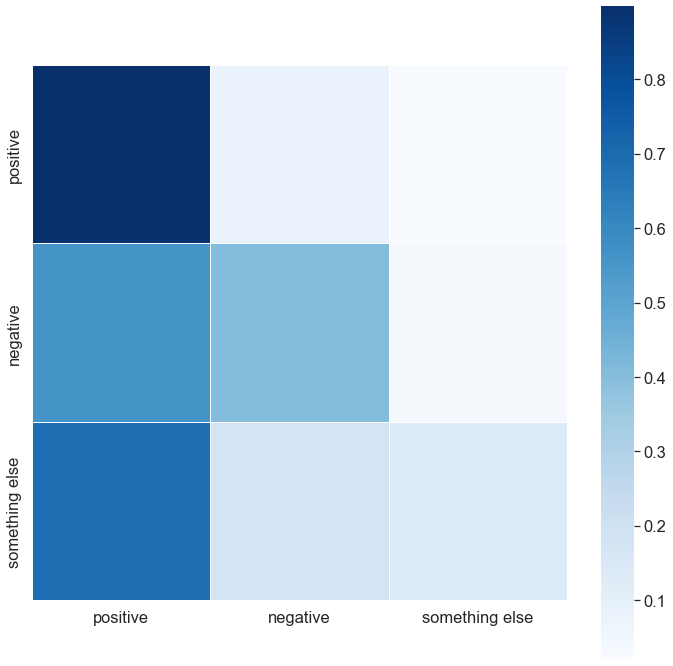

In [20]:
batch_size = 128
device = torch.device('cuda:0')
results_df = pd.DataFrame(columns = ['Top1', 'Top2', 'Macro-F1'], index = ('emotion', ))
test_dataset = SingleTaskTestDataSet(test, data_labels, train, task)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
model = torch.load(f'best_model_{task}_single_task_ternary.pt').to(device)
with torch.no_grad():
    pred, lab = test_single_task(model, test_loader, train)
results_df['Top1'].loc[task] = compute_topk(lab, pred, k=1)
results_df['Top2'].loc[task] = compute_topk(lab, pred, k=2)
pred_lab = torch.max(torch.Tensor(pred), 1)[1]
results_df['Macro-F1'].loc[task] = f1_score(lab, pred_lab, average = 'macro')
labels = pd.read_csv(f'{root}/mapping/{task}_entidx2name.csv', names = ['idx','name'])['name'].tolist()
plot_confusion_matrix(lab, pred_lab, labels = ['positive', 'negative', 'something else'])

In [22]:
results_df.to_csv('results_single_task_ternary.csv')